In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
from datetime import datetime
import json

In [2]:
store_100_path = r"df_all_store_100.parquet"
store_42_path = r"df_all_store_42.parquet"
store_4906_path = r"df_all_store_4906.parquet"

In [3]:
pl.Config.set_fmt_str_lengths(314)
pl.Config.set_tbl_cols(20)
pl.Config.set_tbl_rows(314)

polars.config.Config

In [4]:
df_100 = pl.read_parquet(store_100_path).drop(columns=["__index_level_0__"])
df_all = df_100.clone()

In [5]:
del df_100

In [6]:
df_42 = pl.read_parquet(store_42_path).drop(columns=["__index_level_0__"])

In [7]:
df_all = pl.concat([df_all, df_42])

In [8]:
del df_42

In [9]:
df_4906 = pl.read_parquet(store_4906_path).drop(columns=["__index_level_0__"])

In [10]:
df_all = pl.concat([df_all, df_4906])

In [11]:
del df_4906

In [12]:
print(f"Memory usage of dataframe is df_all {round(df_all.estimated_size('mb'), 2)} MB")

Memory usage of dataframe is df_all 8487.11 MB


# read data from warehouse

In [13]:
waerhouse_path = r"df_all_store_VZ01.parquet"
df_warehouse = pl.read_parquet(waerhouse_path).drop(columns=["__index_level_0__"])

In [14]:
df_warehouse = df_warehouse.with_columns(pl.col('sku').cast(pl.Utf8))

In [15]:
df_warehouse = df_warehouse.rename({"stock": "warehouse_stock"})

# join data

In [16]:
df_step1 = df_all.join(df_warehouse[["sku","date","warehouse_stock"]], on = ["sku","date"], how = "left")

In [17]:
df_step1 = df_step1.with_columns(pl.col('warehouse_stock').fill_null(0))

In [18]:
df_step1 = df_step1.sort(['sku',"store",'date'])

In [19]:
df_step1 =df_step1.with_columns((pl.col("warehouse_stock").diff().over(["store","sku"]).alias("warehouse_stock_change").fill_nan(0)))

In [20]:
df_step1 = df_step1.with_columns(pl.col('stock').diff().over(["store","sku"]).alias("stock_change").fill_nan(0))

In [21]:
del df_all, df_warehouse

In [22]:
filtered_df_stock = df_step1.filter(pl.col('stock') > 0)
result_df_stock_non_zeros = filtered_df_stock.with_columns(pl.col('stock').first().over(["store","sku"]).alias("first_stock"))

# read dict of stores distribution

In [23]:
dict_per_store_per_year_path = r"dict_per_store_per_year.json"
with open(dict_per_store_per_year_path) as json_file:
    dict_per_store_per_year = json.load(json_file)

In [24]:
dict_per_store_per_year_2022 = dict_per_store_per_year["2022"]

# view

In [25]:
print(df_step1.shape)

(73632871, 12)


In [26]:
dict_per_store_per_year_2022["100"], dict_per_store_per_year_2022["42"], dict_per_store_per_year_2022["82"]

(0.037152098092696574, 0.02105508186996078, 0.0221345022634434)

In [27]:
print(df_step1.head(30))

shape: (30, 12)
┌────────┬───────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ sku    ┆ store ┆ date   ┆ averag ┆ avera ┆ sales ┆ item  ┆ sku_s ┆ stock ┆ wareh ┆ wareh ┆ stock │
│ ---    ┆ ---   ┆ ---    ┆ e_pric ┆ ge_di ┆ ---   ┆ ---   ┆ tore  ┆ ---   ┆ ouse_ ┆ ouse_ ┆ _chan │
│ str    ┆ str   ┆ dateti ┆ e      ┆ count ┆ f64   ┆ str   ┆ ---   ┆ f64   ┆ stock ┆ stock ┆ ge    │
│        ┆       ┆ me[ns] ┆ ---    ┆ ed_pr ┆       ┆       ┆ str   ┆       ┆ ---   ┆ _chan ┆ ---   │
│        ┆       ┆        ┆ f64    ┆ ice   ┆       ┆       ┆       ┆       ┆ f64   ┆ ge    ┆ f64   │
│        ┆       ┆        ┆        ┆ ---   ┆       ┆       ┆       ┆       ┆       ┆ ---   ┆       │
│        ┆       ┆        ┆        ┆ f64   ┆       ┆       ┆       ┆       ┆       ┆ f64   ┆       │
╞════════╪═══════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ 100009 ┆ 100   ┆ 2018-0 ┆ null   ┆ null  ┆ 0.0   ┆ 10000 ┆ 10000 ┆ 0.0   

In [28]:
max_sku_temp = 100630105000002

In [29]:
sku_temp = df_step1.filter((pl.col('sku').is_in(100630105000002))).select(pl.col(["date","stock",'warehouse_stock_change',"sales","stock_change","store","warehouse_stock"]))

In [30]:
stock_init_warehouse_sku = sku_temp.with_columns(pl.col('warehouse_stock').first().over(["store"]).alias("first_stock"))

In [31]:
print(stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0])

3165.0


In [32]:
dict_per_store_per_year_2022["100"]

0.037152098092696574

In [33]:
dict_per_store_per_year_2022["100"] * stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0]

117.58639046338466

In [34]:
dict_per_store_per_year["2020"]["100"]

0.03250624160289353

In [35]:
dict_per_store_per_year["2020"]["100"] * stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0]

102.88225467315803

In [36]:
dict_per_store_per_year["2019"]["100"] * stock_init_warehouse_sku.filter(pl.col("store")=="100").select(pl.col(["first_stock"])).max()[0,0]

133.5723185928597

In [37]:
dict_per_store_per_year_2022["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

66.63933411842586

In [38]:
dict_per_store_per_year["2020"]["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

58.52620685217021

In [39]:
dict_per_store_per_year["2019"]["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

57.19070811057481

In [40]:
dict_per_store_per_year["2018"]["42"] * stock_init_warehouse_sku.filter(pl.col("store")=="42").select(pl.col(["first_stock"])).max()[0,0]

59.36505388212157

In [41]:
print(sku_temp.filter(pl.col("store")=="100").select(pl.col(["sales"])).sum())

shape: (1, 1)
┌───────┐
│ sales │
│ ---   │
│ f64   │
╞═══════╡
│ 51.0  │
└───────┘


In [42]:
print(sku_temp.filter(pl.col("store")=="42").select(pl.col(["sales"])).sum())

shape: (1, 1)
┌───────┐
│ sales │
│ ---   │
│ f64   │
╞═══════╡
│ 53.0  │
└───────┘


In [43]:
print(sku_temp.filter(pl.col("store")=="4906").select(pl.col(["sales"])).sum())


shape: (1, 1)
┌───────┐
│ sales │
│ ---   │
│ f64   │
╞═══════╡
│ 22.0  │
└───────┘


In [44]:
print(sku_temp.filter(pl.col("store")=="100").filter(pl.col('stock_change')<0).sum())

shape: (1, 7)
┌──────────────┬───────┬────────────────────────┬───────┬──────────────┬───────┬─────────────────┐
│ date         ┆ stock ┆ warehouse_stock_change ┆ sales ┆ stock_change ┆ store ┆ warehouse_stock │
│ ---          ┆ ---   ┆ ---                    ┆ ---   ┆ ---          ┆ ---   ┆ ---             │
│ datetime[ns] ┆ f64   ┆ f64                    ┆ f64   ┆ f64          ┆ str   ┆ f64             │
╞══════════════╪═══════╪════════════════════════╪═══════╪══════════════╪═══════╪═════════════════╡
│ null         ┆ 370.0 ┆ -276.0                 ┆ 13.0  ┆ -53.0        ┆ null  ┆ 9589.0          │
└──────────────┴───────┴────────────────────────┴───────┴──────────────┴───────┴─────────────────┘


In [45]:
print(sku_temp.filter(pl.col("store")=="42").filter(pl.col('stock_change')<0).sum())

shape: (1, 7)
┌──────────────┬───────┬────────────────────────┬───────┬──────────────┬───────┬─────────────────┐
│ date         ┆ stock ┆ warehouse_stock_change ┆ sales ┆ stock_change ┆ store ┆ warehouse_stock │
│ ---          ┆ ---   ┆ ---                    ┆ ---   ┆ ---          ┆ ---   ┆ ---             │
│ datetime[ns] ┆ f64   ┆ f64                    ┆ f64   ┆ f64          ┆ str   ┆ f64             │
╞══════════════╪═══════╪════════════════════════╪═══════╪══════════════╪═══════╪═════════════════╡
│ null         ┆ 442.0 ┆ -381.0                 ┆ 7.0   ┆ -55.0        ┆ null  ┆ 13714.0         │
└──────────────┴───────┴────────────────────────┴───────┴──────────────┴───────┴─────────────────┘


In [46]:
# sku_temp.filter(pl.col("store")=="42").select(pl.col(["date","stock",'warehouse_stock_change',"sales","stock_change","store","warehouse_stock"]))

# dict compare dist caculation to actual from sales

In [47]:
stock_init_warehouse_sku = df_step1.filter(pl.col("warehouse_stock")>0).groupby(["sku"]).agg(pl.col("warehouse_stock").first().alias("total_stock_from_warehouse"))

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/855338996.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  stock_init_warehouse_sku = df_step1.filter(pl.col("warehouse_stock")>0).groupby(["sku"]).agg(pl.col("warehouse_stock").first().alias("total_stock_from_warehouse"))


In [48]:
their_suggestion_stock_init = df_step1.filter(pl.col("stock")>0).groupby(["sku"]).agg(pl.col("stock").first().alias("palmers_suggest_stock_init"))

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/3744170835.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  their_suggestion_stock_init = df_step1.filter(pl.col("stock")>0).groupby(["sku"]).agg(pl.col("stock").first().alias("palmers_suggest_stock_init"))


In [49]:
df_step1.filter(pl.col("sku")=="100090841000004")

sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change
str,str,datetime[ns],f64,f64,f64,str,str,f64,f64,f64,f64
"""100090841000004""","""100""",2017-12-20 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,null,null
"""100090841000004""","""100""",2017-12-21 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-22 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-23 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-24 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-25 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-26 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-27 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0
"""100090841000004""","""100""",2017-12-28 00:00:00,null,null,0.0,"""100090841000""","""100090841000004,100""",4.0,0.0,0.0,0.0


In [50]:
print(stock_init_warehouse_sku.head(3))

shape: (3, 2)
┌─────────────────┬────────────────────────────┐
│ sku             ┆ total_stock_from_warehouse │
│ ---             ┆ ---                        │
│ str             ┆ f64                        │
╞═════════════════╪════════════════════════════╡
│ 100628237000009 ┆ 179.0                      │
│ 100654178000003 ┆ 1459.0                     │
│ 100517198000004 ┆ 191.0                      │
└─────────────────┴────────────────────────────┘


In [51]:
stock_init_warehouse_sku.groupby(["sku"]).agg(pl.col("total_stock_from_warehouse").sum())["sku"]

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/4049317997.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  stock_init_warehouse_sku.groupby(["sku"]).agg(pl.col("total_stock_from_warehouse").sum())["sku"]


sku
str
"""100548462000003"""
"""100653034000002"""
"""100618456000006"""
"""100559378000002"""
"""100085156000002"""
"""100610486000001"""
"""100649418000004"""
"""100659103000003"""
"""100553960000004"""


In [52]:
stock_init_warehouse_sku.groupby(["sku"]).agg(pl.col("total_stock_from_warehouse").sum())

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/125524530.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  stock_init_warehouse_sku.groupby(["sku"]).agg(pl.col("total_stock_from_warehouse").sum())


sku,total_stock_from_warehouse
str,f64
"""100659515000003""",234.0
"""100553783000012""",169.0
"""100642316000001""",442.0
"""100559181000001""",164.0
"""100085101000003""",327.0
"""100525853000004""",257.0
"""100628201000008""",164.0
"""100628056000002""",164.0
"""100631054000002""",307.0


In [53]:
temp_100_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["100"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()
temp_42_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["42"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()
temp_4906_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["4906"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/1320208819.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_100_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["100"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/1320208819.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_42_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["42"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/1320208819.py:3: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_4906_weighted = stock_init_warehouse_sku.groupby(["sku"]).agg(dict_per_store_per_year["2020"]["4906"] * pl.col("total_stock_from_warehouse").sum()).to_pandas()


In [54]:
temp_100_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["100"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()
temp_42_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["42"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()
temp_4906_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["4906"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/383890670.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_100_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["100"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/383890670.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_42_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["42"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/383890670.py:3: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  temp_4906_our = stock_init_warehouse_sku.groupby(["sku"]).agg((dict_per_store_per_year["2020"]["4906"] * pl.col("total_stock_from_warehouse").sum()*1/3).round(0)).to_p

In [123]:
temp_4906_our

,sku,literal,store
0,100552262000001,0.0,4906
1,100618053000008,1.0,4906
2,100659018000002,2.0,4906
3,100628406000004,1.0,4906
4,100552693000001,1.0,4906
...,...,...,...
22074,100635005000001,0.0,4906
22075,100653283000003,1.0,4906
22076,100618341000002,1.0,4906
22077,100532046000001,0.0,4906


In [55]:
# temp_100_our.with_columns(pl.col("store").fill_null("100"))
# temp_42_our.with_columns(pl.col("store").fill_null("42"))

In [56]:
temp_42_our[temp_42_our['sku'] == '100630105000002']

,sku,literal
12945,100630105000002,20.0


In [57]:
temp_100_our[temp_100_our['sku'] == '100630105000002']

,sku,literal
9459,100630105000002,34.0


In [59]:
temp_4906_our[temp_4906_our['sku'] == '100630105000002']


,sku,literal
11731,100630105000002,7.0


In [58]:
sales_100 = df_step1.filter(pl.col("store")=="100").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()
sales_42 = df_step1.filter(pl.col("store")=="42").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()
sales_4906 = df_step1.filter(pl.col("store")=="4906").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()

/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/3490639165.py:1: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  sales_100 = df_step1.filter(pl.col("store")=="100").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/3490639165.py:2: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  sales_42 = df_step1.filter(pl.col("store")=="42").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()
/var/folders/sv/p02my_xx7t193mwjyb2ytt040000gn/T/ipykernel_31325/3490639165.py:3: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  sales_4906 = df_step1.filter(pl.col("store")=="4906").groupby(["sku"]).agg(pl.col("sales").sum()).to_pandas()


In [60]:
temp_100_our['store'] = "100"
temp_42_our['store'] = "42"
temp_4906_our['store'] = "4906"
temp_42_100_our = pd.concat([temp_100_our, temp_42_our, temp_4906_our])


In [61]:
temp_42_our

,sku,literal,store
0,100632068000001,4.0,42
1,100611016000003,1.0,42
2,100628030000002,3.0,42
3,100642162000005,3.0,42
4,100659503000003,2.0,42
...,...,...,...
22074,100552851000001,2.0,42
22075,100642480000005,1.0,42
22076,100630483000001,13.0,42
22077,100535073000003,0.0,42


In [62]:
df_step1 = df_step1.to_pandas()

In [63]:
df_step1 = df_step1.merge(temp_42_100_our, on = ["sku", 'store'], how = "left")

In [64]:
df_step1 = df_step1.rename(columns={"literal": "sum_of_our_allocation_stock"})

In [100]:
f_sales_v = pd.read_csv(r"f_sales_v_fashion.csv")

In [101]:
f_sales_v_100 = f_sales_v[f_sales_v['store'] == 100]
f_sales_v_42 = f_sales_v[f_sales_v['store'] == 42]
f_sales_v_4906 = f_sales_v[f_sales_v['store'] == 4906]

In [102]:
f_sales_v_100

,sku,store,date,average_price,average_dicounted_price,total_sales
7,100009158000001,100,2018-01-30,69.99,69.99,1.0
8,100009158000001,100,2018-02-02,69.99,69.99,1.0
9,100009158000001,100,2018-02-14,69.99,69.99,3.0
10,100009158000001,100,2018-02-16,69.99,69.99,1.0
11,100009158000001,100,2018-02-17,69.99,69.99,1.0
...,...,...,...,...,...,...
4977652,201999999991001,100,2019-11-25,2.99,0.00,1.0
4977653,201999999991001,100,2019-12-17,2.99,2.99,1.0
4977654,201999999991001,100,2019-12-19,2.99,2.99,1.0
4977655,201999999991001,100,2020-12-21,2.99,2.99,2.0


In [108]:
sku_list_stock = set(temp_100_our['sku'].astype(str).unique()).intersection(temp_42_our['sku'].astype(str).unique(), temp_4906_our['sku'].astype(str).unique())
sku_list_f_sales_v = set(f_sales_v_100['sku'].astype(str).unique()).intersection(f_sales_v_42['sku'].astype(str).unique(), f_sales_v_4906['sku'].astype(str).unique())
sku_list = sku_list_stock.intersection(sku_list_f_sales_v)

In [76]:
df_step1 = df_step1[df_step1['sku'].isin(sku_list)]


In [109]:
sku_list

{'100630473000003',
 '100552447000003',
 '100632554000010',
 '100060052000001',
 '100618202000008',
 '100620340000002',
 '100653029000003',
 '100652572000002',
 '100618975000001',
 '100532268000004',
 '100553607000002',
 '100557052000005',
 '100542039000002',
 '100618403000001',
 '100652037000005',
 '100620340000004',
 '100080133000002',
 '100559082000004',
 '100552849000002',
 '100653109000008',
 '100643028000001',
 '100532287000004',
 '100618151000008',
 '100652074000001',
 '100530463000001',
 '100628039000006',
 '100632038000002',
 '100528016000002',
 '100620206000002',
 '100528025000008',
 '100618116000003',
 '100648131000003',
 '100653311000004',
 '100620137000001',
 '100643164000002',
 '100628343000007',
 '100630105000003',
 '100630411000006',
 '100642185000002',
 '100648154000001',
 '100659157000003',
 '100539077000003',
 '100645002000001',
 '100652553000003',
 '100553817000001',
 '100532091000003',
 '100640016000001',
 '100552873000001',
 '100060031000001',
 '100630280000008',


In [104]:
df_step1

{100080128000001,
 100090880000001,
 100528128000002,
 100528128000003,
 100528128000004,
 100528128000005,
 100528128000006,
 100528128000007,
 100548608000004,
 100548608000001,
 100548608000002,
 100553728000003,
 100535296000004,
 100653059000005,
 100653059000006,
 100659740000003,
 100653059000007,
 100654244000001,
 100659501000002,
 100654244000002,
 100630329000001,
 100630329000002,
 100085049000003,
 100630329000003,
 100535097000005,
 100535097000006,
 100535097000007,
 100535097000008,
 100639033000002,
 100659001000001,
 100659001000002,
 100659001000003,
 100628050000002,
 100628050000003,
 100632140000002,
 100632140000003,
 100610427000001,
 100610427000002,
 100610427000003,
 100654250000001,
 100630083000001,
 100654250000002,
 100553842000001,
 100553842000002,
 100549746000001,
 100549746000002,
 100628082000002,
 100628082000003,
 100628082000006,
 100630083000002,
 100628082000009,
 100630083000003,
 100630083000004,
 100630130000003,
 100630442000003,
 100633202

In [82]:
for id in sku_store_df_step_g.groups:
    sku_store_df_step = sku_store_df_step_g.get_group(id)
    sku_store_df_step['sales_cum_sum'] = sku_store_df_step['sales'].cumsum()
    sku_store_df_step['sales_normalized_by_days'] = sku_store_df_step['sales_cum_sum'] / sku_store_df_step['days_from_first_stock']
    sku_store_df_step['our_dynamic_stock'] = sku_store_df_step['sum_of_our_allocation_stock'] - sku_store_df_step['sales_cum_sum']
    sku_store_df_step.set_index('date')[['sum_of_our_allocation_stock','our_dynamic_stock', 'sales_cum_sum','stock']].plot(figsize=(17, 5))
    plt.title(f"sku {id[0]}, store {id[1]}")
    plt.show()



KeyboardInterrupt



In [ ]:
sku_store_df_step_g = df_step1.groupby(["sku", "store"])


In [189]:
#import plt
import warnings
warnings.filterwarnings('ignore')
df_step1['date'] = pd.to_datetime(df_step1['date'])
import matplotlib.pyplot as plt
dict_when_our_stock_go_to_zero = {}
i = 0
for store in ['42', '100', '4906']:
    dict_when_our_stock_go_to_zero[store] = {}
    for sku in sku_list:

        i += 1
        print(i, sku, store)
        sku_store_df_step = sku_store_df_step_g.get_group((sku, store))
        # find in stock the first time that is not zero
        if len(sku_store_df_step[sku_store_df_step["stock"]>0]) == 0:
            continue
        first_stock = sku_store_df_step[sku_store_df_step["stock"]>0]["stock"].iloc[0]
        # nan in our_stock if before first stock
        sku_store_df_step.loc[sku_store_df_step["date"]<sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0], "sum_of_our_allocation_stock"] = np.nan
        # add number of days from first stock 1 2 3 4 5 6 7 8 9 10
        sku_store_df_step['days_from_first_stock'] = np.nan
        sku_store_df_step.loc[sku_store_df_step["date"]>=sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0], "days_from_first_stock"] = sku_store_df_step[sku_store_df_step["date"]>=sku_store_df_step[sku_store_df_step["stock"]>0]["date"].iloc[0]].index - sku_store_df_step[sku_store_df_step["stock"]>0].index[0]

        sku_store_df_step['sales_cum_sum'] = sku_store_df_step['sales'].cumsum()
      #  sku_store_df_step['sales_normalized_by_days'] = sku_store_df_step['sales_cum_sum'] / sku_store_df_step['days_from_first_stock']
        sku_store_df_step['our_dynamic_stock'] = sku_store_df_step['sum_of_our_allocation_stock'] - sku_store_df_step['sales_cum_sum']
        # sku_store_df_step.set_index('date')[['sum_of_our_allocation_stock','our_dynamic_stock', 'sales_cum_sum','stock']].plot(figsize=(17, 5))
        # plt.title(f"sku {sku}, store {store}")
        # plt.show()
        #dict_when_our_stock_go_to_zero[store][sku] =
        if sku_store_df_step.dropna(subset='our_dynamic_stock')['our_dynamic_stock'].iloc[0] > 0 :
            sku_store_df_step_no_na = sku_store_df_step.dropna(subset='our_dynamic_stock')
            if len(sku_store_df_step_no_na[sku_store_df_step_no_na['our_dynamic_stock'] <= 0]) > 0:
                value_of_days_to_zero_our_stock =  sku_store_df_step_no_na[sku_store_df_step_no_na['our_dynamic_stock'] <= 0]['days_from_first_stock'].iloc[0]
                if value_of_days_to_zero_our_stock > 365:
                    value_of_days_to_zero_our_stock = 365
                if value_of_days_to_zero_our_stock == 1:
                    if sku_store_df_step_no_na['stock'].iloc[0] == 1:
                        continue


                dict_when_our_stock_go_to_zero[store][sku] = value_of_days_to_zero_our_stock



1 100630473000003 42
2 100552447000003 42
3 100632554000010 42
4 100060052000001 42
5 100618202000008 42
6 100620340000002 42
7 100653029000003 42
8 100652572000002 42
9 100618975000001 42
10 100532268000004 42
11 100553607000002 42
12 100557052000005 42
13 100542039000002 42
14 100618403000001 42
15 100652037000005 42
16 100620340000004 42
17 100080133000002 42
18 100559082000004 42
19 100552849000002 42
20 100653109000008 42
21 100643028000001 42
22 100532287000004 42
23 100618151000008 42
24 100652074000001 42
25 100530463000001 42
26 100628039000006 42
27 100632038000002 42
28 100528016000002 42
29 100620206000002 42
30 100528025000008 42
31 100618116000003 42
32 100648131000003 42
33 100653311000004 42
34 100620137000001 42
35 100643164000002 42
36 100628343000007 42
37 100630105000003 42
38 100630411000006 42
39 100642185000002 42
40 100648154000001 42
41 100659157000003 42
42 100539077000003 42
43 100645002000001 42
44 100652553000003 42
45 100553817000001 42
46 100532091000003 

In [188]:
sku_store_df_step.iloc[:20]

,sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change,sum_of_our_allocation_stock,days_from_first_stock,sales_cum_sum,our_dynamic_stock
42794617,100618047000001,4906,2019-10-11,NaN,NaN,0.0,100618047000,"100618047000001,4906",0.0,468.0,NaN,NaN,NaN,NaN,0.0,NaN
42794618,100618047000001,4906,2019-10-12,NaN,NaN,0.0,100618047000,"100618047000001,4906",0.0,468.0,0.0,0.0,NaN,NaN,0.0,NaN
42794619,100618047000001,4906,2019-10-13,NaN,NaN,0.0,100618047000,"100618047000001,4906",0.0,468.0,0.0,0.0,NaN,NaN,0.0,NaN
42794620,100618047000001,4906,2019-10-14,NaN,NaN,0.0,100618047000,"100618047000001,4906",0.0,468.0,0.0,0.0,NaN,NaN,0.0,NaN
42794621,100618047000001,4906,2019-10-15,NaN,NaN,0.0,100618047000,"100618047000001,4906",0.0,468.0,0.0,0.0,NaN,NaN,0.0,NaN
42794622,100618047000001,4906,2019-10-16,NaN,NaN,0.0,100618047000,"100618047000001,4906",0.0,468.0,0.0,0.0,NaN,NaN,0.0,NaN
42794623,100618047000001,4906,2019-10-17,NaN,NaN,0.0,100618047000,"100618047000001,4906",0.0,350.0,-118.0,0.0,NaN,NaN,0.0,NaN
42794624,100618047000001,4906,2019-10-18,NaN,NaN,0.0,100618047000,"100618047000001,4906",0.0,255.0,-95.0,0.0,NaN,NaN,0.0,NaN
42794625,100618047000001,4906,2019-10-19,NaN,NaN,0.0,100618047000,"100618047000001,4906",2.0,236.0,-19.0,2.0,1.0,0.0,0.0,1.0
42794626,100618047000001,4906,2019-10-20,59.99,50.99,1.0,100618047000,"100618047000001,4906",2.0,236.0,0.0,0.0,1.0,1.0,1.0,0.0


In [190]:
dict_when_our_stock_go_to_zero_pd = pd.DataFrame.from_dict(dict_when_our_stock_go_to_zero['42'], orient='index', columns=['days_to_zero_our_stock'])
dict_when_our_stock_go_to_zero_pd = pd.concat([dict_when_our_stock_go_to_zero_pd, pd.DataFrame.from_dict(dict_when_our_stock_go_to_zero['100'], orient='index', columns=['days_to_zero_our_stock'])])
dict_when_our_stock_go_to_zero_pd = pd.concat([dict_when_our_stock_go_to_zero_pd, pd.DataFrame.from_dict(dict_when_our_stock_go_to_zero['4906'], orient='index', columns=['days_to_zero_our_stock'])])

### hist of how many days initial stock of 1/3 go to zero

array([[<Axes: title={'center': 'days_to_zero_our_stock'}>]], dtype=object)

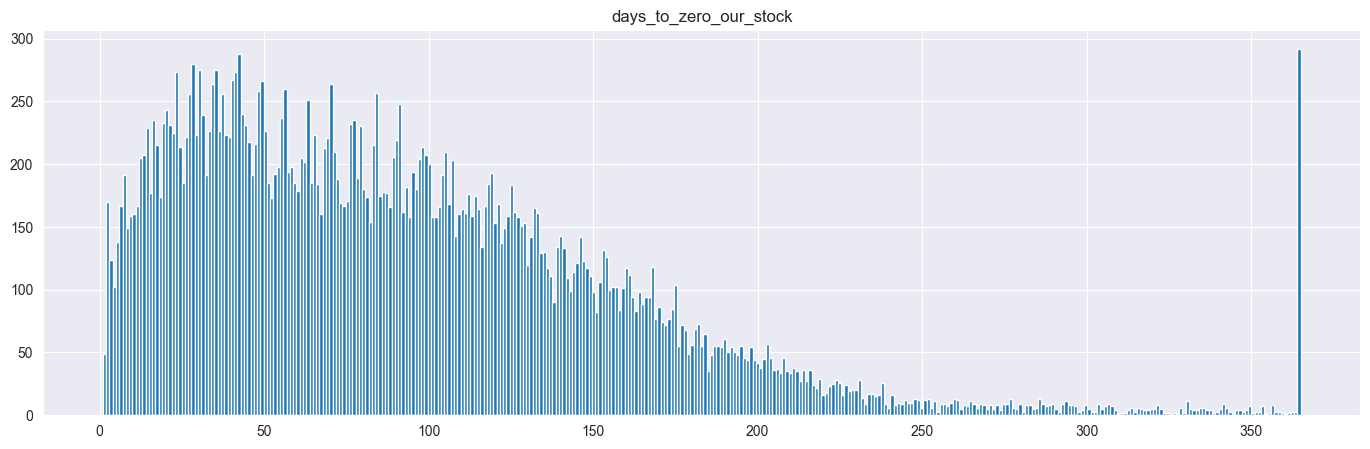

In [194]:
dict_when_our_stock_go_to_zero_pd.hist(bins=365, figsize=(17, 5))

In [160]:
sku_store_df_step[sku_store_df_step["stock"]>0]

,sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change,sum_of_our_allocation_stock


In [157]:
dict_when_our_stock_go_to_zero

{'42': {'100630105000002': 66.0},
 '100': {'100630105000002': 195.0},
 '4906': {'100630105000002': 33.0}}

In [151]:
sku_store_df_step_no_na

,sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change,sum_of_our_allocation_stock,days_from_first_stock,sales_cum_sum,our_dynamic_stock
56937953,100630105000002,100,2020-09-11,NaN,NaN,0.0,100630105000,"100630105000002,100",25.0,2203.0,-962.0,25.0,34.0,0.0,0.0,34.0
56937954,100630105000002,100,2020-09-12,24.99,24.99,2.0,100630105000,"100630105000002,100",25.0,1490.0,-713.0,0.0,34.0,1.0,2.0,32.0
56937955,100630105000002,100,2020-09-13,NaN,NaN,0.0,100630105000,"100630105000002,100",23.0,1490.0,0.0,-2.0,34.0,2.0,2.0,32.0
56937956,100630105000002,100,2020-09-14,NaN,NaN,0.0,100630105000,"100630105000002,100",23.0,1490.0,0.0,0.0,34.0,3.0,2.0,32.0
56937957,100630105000002,100,2020-09-15,NaN,NaN,0.0,100630105000,"100630105000002,100",23.0,1391.0,-99.0,0.0,34.0,4.0,2.0,32.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56939136,100630105000002,100,2023-12-08,NaN,NaN,0.0,100630105000,"100630105000002,100",0.0,0.0,0.0,0.0,34.0,1183.0,51.0,-17.0
56939137,100630105000002,100,2023-12-09,NaN,NaN,0.0,100630105000,"100630105000002,100",0.0,0.0,0.0,0.0,34.0,1184.0,51.0,-17.0
56939138,100630105000002,100,2023-12-10,NaN,NaN,0.0,100630105000,"100630105000002,100",0.0,0.0,0.0,0.0,34.0,1185.0,51.0,-17.0
56939139,100630105000002,100,2023-12-11,NaN,NaN,0.0,100630105000,"100630105000002,100",0.0,0.0,0.0,0.0,34.0,1186.0,51.0,-17.0


In [145]:
sku_store_df_step_no_na = sku_store_df_step.dropna(subset='our_dynamic_stock')
sku_store_df_step_no_na[sku_store_df_step_no_na['sum_of_our_allocation_stock'] <= 0]

IndexError: single positional indexer is out-of-bounds

In [133]:
sku_store_df_step.iloc[-20:]

,sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change,sum_of_our_allocation_stock,days_from_first_stock,sales_cum_sum,our_dynamic_stock
45545496,100618213000008,100,2023-11-23,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,842.0,2.0,0.0
45545497,100618213000008,100,2023-11-24,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,843.0,2.0,0.0
45545498,100618213000008,100,2023-11-25,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,844.0,2.0,0.0
45545499,100618213000008,100,2023-11-26,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,845.0,2.0,0.0
45545500,100618213000008,100,2023-11-27,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,846.0,2.0,0.0
45545501,100618213000008,100,2023-11-28,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,847.0,2.0,0.0
45545502,100618213000008,100,2023-11-29,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,848.0,2.0,0.0
45545503,100618213000008,100,2023-11-30,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,849.0,2.0,0.0
45545504,100618213000008,100,2023-12-01,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,850.0,2.0,0.0
45545505,100618213000008,100,2023-12-02,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,0.0,0.0,0.0,2.0,851.0,2.0,0.0


In [122]:
sku_store_df_step.iloc[:20]

,sku,store,date,average_price,average_dicounted_price,sales,item,sku_store,stock,warehouse_stock,warehouse_stock_change,stock_change,sum_of_our_allocation_stock,days_from_first_stock,sales_cum_sum,our_dynamic_stock
45544641,100618213000008,100,2021-07-21,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,NaN,NaN,NaN,NaN,0.0,NaN
45544642,100618213000008,100,2021-07-22,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544643,100618213000008,100,2021-07-23,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544644,100618213000008,100,2021-07-24,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544645,100618213000008,100,2021-07-25,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544646,100618213000008,100,2021-07-26,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544647,100618213000008,100,2021-07-27,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544648,100618213000008,100,2021-07-28,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544649,100618213000008,100,2021-07-29,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN
45544650,100618213000008,100,2021-07-30,NaN,NaN,0.0,100618213000,"100618213000008,100",0.0,177.0,0.0,0.0,NaN,NaN,0.0,NaN


In [95]:
'100531067000003' in temp_42_our['sku'].unique()

True

In [99]:
print(df_step1[(df_step1['sku'] == '100531067000003') & (df_step1['store'] == '4906')])

                      sku store       date  average_price  \
14612941  100531067000003  4906 2020-02-12            NaN   
14612942  100531067000003  4906 2020-02-13            NaN   
14612943  100531067000003  4906 2020-02-14            NaN   
14612944  100531067000003  4906 2020-02-14            NaN   
14612945  100531067000003  4906 2020-02-15            NaN   
...                   ...   ...        ...            ...   
14614338  100531067000003  4906 2023-12-08            NaN   
14614339  100531067000003  4906 2023-12-09            NaN   
14614340  100531067000003  4906 2023-12-10            NaN   
14614341  100531067000003  4906 2023-12-11            NaN   
14614342  100531067000003  4906 2023-12-12            NaN   

          average_dicounted_price  sales          item             sku_store  \
14612941                      NaN    0.0  100531067000  100531067000003,4906   
14612942                      NaN    0.0  100531067000  100531067000003,4906   
14612943                   

In [ ]:
sku_store_df_step.iloc[:50]

In [ ]:
sku_store_df_step.set_index('date')[['stock', 'sum_of_our_allocation_stock', 'sales', 'our_dynamic_stock']]

In [ ]:
for days in [20,40, 60, 80, 100]:
    slice_data = sku_store_df_step.iloc[:days]
    if slice_data['sales_cum_sum'].iloc[-1] >= slice_data['sum_of_our_allocation_stock'].iloc[-1] / 2:
        print(f"day: {days},")
        break


In [ ]:
slice_data